<center> 
    <h1>Mini-project1</h1>
    <h2>Predict the laterality of upcoming finger movements</h2>
</center>

#### Imports

In [2]:
import math
import numpy as np
import matplotlib.pylab as plt
import dlc_bci as bci
from types import SimpleNamespace 

from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# baselines
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import torch 
from torch import nn
from torch import Tensor
from torch.autograd import Variable
from torch.optim import Adam
from torch import optim
import torch.nn.functional as F

from helpers import *
from modelWrapper import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Download/load the dataset

In [3]:
one_khz=False

train = SimpleNamespace()
train.X, train.y = bci.load(root='./data_bci', one_khz=one_khz)
print(str(type(train.X)), train.X.size())
print(str(type(train.y)), train.y.size())

test = SimpleNamespace()
test.X, test.y = bci.load(root='./data_bci', train=False, one_khz=one_khz)
print(str(type(test.X)), test.X.size())
print(str(type(test.y)), test.y.size())

<class 'torch.FloatTensor'> torch.Size([316, 28, 50])
<class 'torch.LongTensor'> torch.Size([316])
<class 'torch.FloatTensor'> torch.Size([100, 28, 50])
<class 'torch.LongTensor'> torch.Size([100])


In [4]:
i = 1
plt.imshow(X_tr[i])
plt.show()

NameError: name 'X_tr' is not defined

## Baselines:

### Random Forest

- Preprocess data

In [192]:
# flatten the X (no standardization for random forest) 
X_tr, y_tr = train.X.view(train.X.shape[0], -1).clone().numpy(), train.y.numpy() 
X_te, y_te = test.X.view(test.X.shape[0], -1).clone().numpy(), test.y.numpy() 
X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

((316, 1400), (316,), (100, 1400), (100,))

- Tune and compute test accuracy.

Best depth: 5
Test score: 0.58


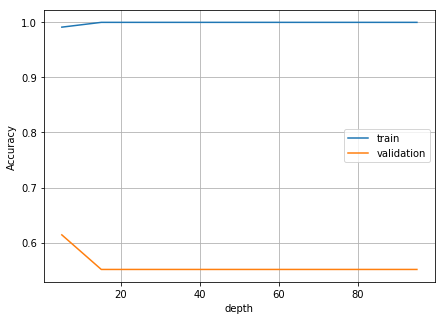

In [193]:
depths = np.arange(5, 100, 10) # grid search on a parameter of the model

# here we store all the scores obtained with the different depths
randForest = {
    "tr_scores": [],
    "va_scores": []
}

for depth in depths:
    result = cross_validate(
        RandomForestClassifier(n_estimators=100, max_depth=depth, n_jobs=-1, random_state=1), 
        X_tr, y_tr, cv=5, return_train_score=True)
    
    randForest["tr_scores"].append(np.mean(result["train_score"]))
    randForest["va_scores"].append(np.mean(result["test_score"]))
    
plot_scores(depths, "depth", randForest["tr_scores"], randForest["va_scores"], ylog_scale=False)

best_depth = depths[np.argmax(randForest["va_scores"])]
print('Best depth:', best_depth)
print('Test score:',
      RandomForestClassifier(n_estimators=100, max_depth=depth, n_jobs=-1, random_state=1)
      .fit(X_tr, y_tr)
      .score(X_te, y_te))

### Logistic regression

- Preprocess data

In [194]:
# flatten and normalize the X
X_tr, y_tr = train.X.view(train.X.shape[0], -1).clone().numpy(), train.y.numpy() 
X_te, y_te = test.X.view(test.X.shape[0], -1).clone().numpy(), test.y.numpy() 

scaler = StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)
X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

((316, 1400), (316,), (100, 1400), (100,))

- Tune and compute test accuracy.

Best lambda: 0.215443469003
Test score: 0.7


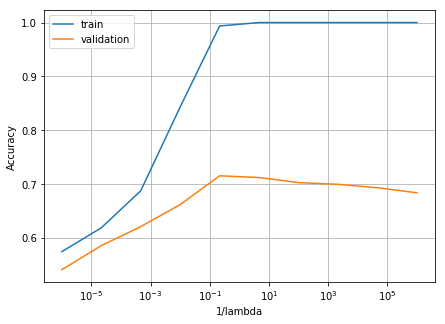

In [195]:
lambdas = np.logspace(-6, 6, 10) # grid search on a parameter of the model

# here we store all the scores obtained with the different lambdas
logreg = {
    "tr_scores": [],
    "va_scores": []
}

# tune the model on the train set 
for lambda_ in lambdas:
    result = cross_validate(LogisticRegression(C=lambda_), X_tr, y_tr, cv=5, return_train_score=True)
    
    logreg["tr_scores"].append(np.mean(result["train_score"]))
    logreg["va_scores"].append(np.mean(result["test_score"]))
    
plot_scores(lambdas, "1/lambda", logreg["tr_scores"], logreg["va_scores"], ylog_scale=True)

# select the best lambdas and estimate the accuracy on the test set
best_lambda = lambdas[np.argmax(logreg["va_scores"])]
print('Best lambda:', best_lambda)
print('Test score:', 
      LogisticRegression(C=best_lambda)
      .fit(X_tr, y_tr)
      .score(X_te, y_te))

## Support vector machine

- Preprocess data

In [ ]:
# flatten and normalize the X
X_tr, y_tr = train.X.view(train.X.shape[0], -1).clone().numpy(), train.y.numpy() 
X_te, y_te = test.X.view(test.X.shape[0], -1).clone().numpy(), test.y.numpy() 

scaler = StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)
X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

- Tune and compute test accuracy.

In [ ]:
lambdas = np.logspace(-6, 6, 10) # grid search on a parameter of the model

# here we store all the scores obtained with the different lambdas
logreg = {
    "tr_scores": [],
    "va_scores": []
}

# tune the model on the train set 
for lambda_ in lambdas:
    result = cross_validate(SVC(C=lambda_), X_tr, y_tr, cv=5, return_train_score=True)
    
    logreg["tr_scores"].append(np.mean(result["train_score"]))
    logreg["va_scores"].append(np.mean(result["test_score"]))
    
plot_scores(lambdas, "1/lambda", logreg["tr_scores"], logreg["va_scores"], ylog_scale=True)

# select the best lambdas and estimate the accuracy on the test set
best_lambda = lambdas[np.argmax(logreg["va_scores"])]
print('Best lambda:', best_lambda)
print('Test score:', 
      SVC(C=best_lambda)
      .fit(X_tr, y_tr)
      .score(X_te, y_te))

### LinearDiscriminantAnalysis

- Preprocess data

In [ ]:
# flatten and normalize the X
X_tr, y_tr = train.X.view(train.X.shape[0], -1).clone().numpy(), train.y.numpy() 
X_te, y_te = test.X.view(test.X.shape[0], -1).clone().numpy(), test.y.numpy() 

scaler = StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)
X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

- Tune and compute test accuracy.

In [ ]:
tols = np.logspace(-6, 1, 10) # grid search on a parameter of the model

# here we store all the scores obtained with the different lambdas
logreg = {
    "tr_scores": [],
    "va_scores": []
}

# tune the model on the train set 
for tol in tols:
    result = cross_validate(LinearDiscriminantAnalysis(tol=tol), X_tr, y_tr, cv=5, return_train_score=True)
    
    logreg["tr_scores"].append(np.mean(result["train_score"]))
    logreg["va_scores"].append(np.mean(result["test_score"]))
    
plot_scores(tols, "tol", logreg["tr_scores"], logreg["va_scores"], ylog_scale=True)

# select the best lambdas and estimate the accuracy on the test set
best_tol = tols[np.argmax(logreg["va_scores"])]
print('Best tol:', best_tol)
print('Test score:', 
      LinearDiscriminantAnalysis(tol=best_tol)
      .fit(X_tr, y_tr)
      .score(X_te, y_te))

### K-Nearest Neighbors

- Preprocess data

In [ ]:
# flatten, normalize the X and apply PCA to reduce dimensions (reduce curse of dimensionality effect)
X_tr, y_tr = train.X.view(train.X.shape[0], -1).clone().numpy(), train.y.numpy() 
X_te, y_te = test.X.view(test.X.shape[0], -1).clone().numpy(), test.y.numpy() 

scaler = StandardScaler()
scaler.fit(X_tr)
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)

pca = PCA(n_components=0.95)
pca.fit(X_tr_scaled)
X_tr = pca.transform(X_tr)
X_te = pca.transform(X_te)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

- Tune and compute test accuracy.

In [ ]:
Ks = np.arange(1, 10, 1) # grid search on a parameter of the model

# here we store all the scores obtained with the different number of neighbors
nearestNeig = {
    "tr_scores": [],
    "va_scores": []
}

for k in Ks:
    result = cross_validate(
        KNeighborsClassifier(n_neighbors=k), 
        X_tr, y_tr, cv=5, return_train_score=True)
    
    nearestNeig["tr_scores"].append(np.mean(result["train_score"]))
    nearestNeig["va_scores"].append(np.mean(result["test_score"]))
    
plot_scores(Ks, "# Neighbors", nearestNeig["tr_scores"], nearestNeig["va_scores"], ylog_scale=False)

best_k = Ks[np.argmax(nearestNeig["va_scores"])]
print('Best k:', best_k)
print('Test score:', 
      KNeighborsClassifier(n_neighbors=k)
      .fit(X_tr, y_tr)
      .score(X_te, y_te))

## Deep networks

### CNN: 2D convolutional layers

In [3]:
# add a channel to store the pixels image (so to apply the 2D convolutional layer)
X_tr, y_tr = Variable(train.X.clone().unsqueeze(1)), Variable(train.y)
X_te, y_te = Variable(test.X.clone().unsqueeze(1)), Variable(test.y)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

(torch.Size([316, 1, 28, 50]),
 torch.Size([316]),
 torch.Size([100, 1, 28, 50]),
 torch.Size([100]))

In [6]:
class CNN2D(modelWrapper):
    def __init__(self, nb_hidden=50, activation = nn.ReLU):
        super(CNN2D, self).__init__()        
        
        self.activation = activation
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 7), padding=(1, 3)),
            nn.MaxPool2d(2),
            self.activation(),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.MaxPool2d((2, 5)),
            self.activation(),
            
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.MaxPool2d(2, padding=(1, 1)),
            self.activation(),
        )
        
        self.num_features = 384
        self.classifier = nn.Sequential(
            nn.Linear(self.num_features, nb_hidden),
            self.activation(),
            nn.Linear(nb_hidden, 2)
        )
        
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = Adam(self.parameters(), lr=0.001)

In [7]:
model = CNN2D()

In [8]:
model.fit(X_tr, y_tr, X_test=X_te, y_test=y_te, epochs=5)

Epoch 0: Train loss: 17.735598146915436. Train accuracy 49.68%. Test accuracy 51.00%
Epoch 1: Train loss: 11.17670351266861. Train accuracy 50.00%. Test accuracy 49.00%
Epoch 2: Train loss: 11.066096782684326. Train accuracy 59.81%. Test accuracy 49.00%
Epoch 3: Train loss: 11.02427351474762. Train accuracy 57.59%. Test accuracy 45.00%
Epoch 4: Train loss: 10.97516816854477. Train accuracy 64.24%. Test accuracy 54.00%


CNN2D(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 7), stride=(1, 1), padding=(1, 3))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=(2, 5), stride=(2, 5), dilation=(1, 1), ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
    (8): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=384, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=2, bias=True)
  )
  (criterion): CrossEntropyLoss(
  )
)

### 1D convolution +  dropout

In [9]:
X_tr, y_tr = Variable(train.X.clone()), Variable(train.y)
X_te, y_te = Variable(test.X.clone()), Variable(test.y)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

(torch.Size([316, 28, 50]),
 torch.Size([316]),
 torch.Size([100, 28, 50]),
 torch.Size([100]))

In [10]:
# define the network with two convolutional layers
class CNN_1D_Dropout(modelWrapper):
    def __init__(self, nb_hidden=50, activation=nn.ReLU):
        self.nb_hidden = nb_hidden
        super(CNN_1D_Dropout, self).__init__()
        
        self.activation = activation
        self.dropout = nn.Dropout
        
        self.features = nn.Sequential(
            nn.Conv1d(28, 64, kernel_size=5, padding=2),
            self.activation(),
            nn.Dropout(0.1),
            
            nn.Conv1d(64, 64, kernel_size=5, padding=2),
            nn.MaxPool1d(2, padding=1),
            self.activation(),
            nn.Dropout(0.1),
            
            nn.Conv1d(64, 32, kernel_size=5, padding=2),
            nn.MaxPool1d(2, padding=1),
            self.activation(),
        )
        
        self.num_features = 448
        self.classifier = nn.Sequential(
            nn.Linear(self.num_features, nb_hidden),
            self.activation(),
            nn.Linear(nb_hidden, 2)
        )

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = Adam(self.parameters(), lr=0.001)

In [11]:
model = CNN_1D_Dropout()

In [12]:
model.fit(X_tr, y_tr, X_test=X_te, y_test=y_te, epochs=25)

Epoch 0: Train loss: 12.603899657726288. Train accuracy 53.80%. Test accuracy 50.00%
Epoch 1: Train loss: 11.29260778427124. Train accuracy 50.63%. Test accuracy 54.00%
Epoch 2: Train loss: 10.887699127197266. Train accuracy 60.76%. Test accuracy 58.00%
Epoch 3: Train loss: 10.676740527153015. Train accuracy 64.56%. Test accuracy 52.00%
Epoch 4: Train loss: 10.483382821083069. Train accuracy 68.35%. Test accuracy 55.00%
Epoch 5: Train loss: 9.79628637433052. Train accuracy 75.95%. Test accuracy 65.00%
Epoch 6: Train loss: 8.87550476193428. Train accuracy 74.37%. Test accuracy 67.00%
Epoch 7: Train loss: 8.62815609574318. Train accuracy 71.52%. Test accuracy 65.00%
Epoch 8: Train loss: 8.24027106165886. Train accuracy 82.28%. Test accuracy 76.00%
Epoch 9: Train loss: 6.475054711103439. Train accuracy 68.04%. Test accuracy 67.00%
Epoch 10: Train loss: 7.116798236966133. Train accuracy 83.86%. Test accuracy 74.00%
Epoch 11: Train loss: 7.548905938863754. Train accuracy 78.16%. Test accura

CNN_1D_Dropout(
  (features): Sequential(
    (0): Conv1d(28, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): Dropout(p=0.1)
    (3): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Dropout(p=0.1)
    (7): Conv1d(64, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (8): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (9): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=448, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=2, bias=True)
  )
  (criterion): CrossEntropyLoss(
  )
)

### 1D convolution + Batch norm

In [5]:
X_tr, y_tr = Variable(train.X.clone()), Variable(train.y)
X_te, y_te = Variable(test.X.clone()), Variable(test.y)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

(torch.Size([316, 28, 50]),
 torch.Size([316]),
 torch.Size([100, 28, 50]),
 torch.Size([100]))

In [6]:
class CNN_1D_BatchNorm(modelWrapper):
    def __init__(self, nb_hidden=50, activation=nn.ReLU):
        torch.manual_seed(0) 
        super(CNN_1D_BatchNorm, self).__init__()
        
        self.activation = activation
        
        self.features = nn.Sequential(
            nn.BatchNorm1d(28),
            nn.Conv1d(28, 32, kernel_size=5, padding=2),
            self.activation(),
            
            nn.BatchNorm1d(32),
            nn.Conv1d(32, 32, kernel_size=5, padding=2),
            self.activation(),
            
            nn.Dropout(0.1),
            
            nn.BatchNorm1d(32),
            nn.Conv1d(32, 32, kernel_size=5, padding=2),
            self.activation(),
            
            nn.Dropout(0.1),
            
            nn.BatchNorm1d(32),
            nn.Conv1d(32, 32, kernel_size=5, padding=2),
            nn.MaxPool1d(2, padding=1),
            self.activation(),
            
            nn.Dropout(0.1),
            
            nn.BatchNorm1d(32),
            nn.Conv1d(32, 32, kernel_size=5, padding=2),
            nn.MaxPool1d(2),
            self.activation(),
            
            nn.BatchNorm1d(32),
        )
        
        self.num_features = 32*13
        self.classifier = nn.Sequential(
            nn.Linear(self.num_features, nb_hidden),
            self.activation(),
            nn.Linear(nb_hidden, 2)
        )
        
        self.criterion = nn.CrossEntropyLoss()
#         self.optimizer = Adam(self.parameters(), lr=0.0001, weight_decay=1e-1)
        self.optimizer = optim.Adamax(self.parameters(), lr=0.001, weight_decay=1e-2)

In [7]:
model = CNN_1D_BatchNorm(nb_hidden=250, activation=nn.PReLU)

In [8]:
model.fit(X_tr, y_tr, X_test=X_te, y_test=y_te, epochs=100, batch_size=50, save_best_model=True)

Epoch 0: Train loss: 4.897167801856995. Train accuracy 50.32%. Test accuracy 49.00%
Epoch 1: Train loss: 4.475085616111755. Train accuracy 50.32%. Test accuracy 49.00%
Epoch 2: Train loss: 4.137418061494827. Train accuracy 50.32%. Test accuracy 49.00%
Epoch 3: Train loss: 3.783247262239456. Train accuracy 50.32%. Test accuracy 49.00%
Epoch 4: Train loss: 3.502762198448181. Train accuracy 70.25%. Test accuracy 57.00%
Epoch 5: Train loss: 3.1077880859375. Train accuracy 81.96%. Test accuracy 67.00%
Epoch 6: Train loss: 2.7011975944042206. Train accuracy 83.23%. Test accuracy 75.00%
Epoch 7: Train loss: 2.505679413676262. Train accuracy 85.13%. Test accuracy 79.00%
Epoch 8: Train loss: 2.2265518605709076. Train accuracy 87.34%. Test accuracy 74.00%
Epoch 9: Train loss: 2.0717523247003555. Train accuracy 85.13%. Test accuracy 78.00%
Epoch 10: Train loss: 1.9938741326332092. Train accuracy 90.19%. Test accuracy 77.00%
Epoch 11: Train loss: 1.6451536566019058. Train accuracy 90.51%. Test acc

Epoch 95: Train loss: 0.04881105991080403. Train accuracy 99.68%. Test accuracy 83.00%
Epoch 96: Train loss: 0.08783674729056656. Train accuracy 100.00%. Test accuracy 80.00%
Epoch 97: Train loss: 0.10056914947926998. Train accuracy 99.68%. Test accuracy 84.00%
Epoch 98: Train loss: 0.08696066588163376. Train accuracy 99.37%. Test accuracy 82.00%
Epoch 99: Train loss: 0.07340648770332336. Train accuracy 99.37%. Test accuracy 81.00%


CNN_1D_BatchNorm(
  (features): Sequential(
    (0): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (1): Conv1d(28, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (2): PReLU(num_parameters=1)
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True)
    (4): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): PReLU(num_parameters=1)
    (6): Dropout(p=0.1)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True)
    (8): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (9): PReLU(num_parameters=1)
    (10): Dropout(p=0.1)
    (11): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True)
    (12): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (13): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (14): PReLU(num_parameters=1)
    (15): Dropout(p=0.1)
    (16): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True)
    (17): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))


In [9]:
model.score(X_te, y_te), model.load_model().score(X_te, y_te)

(0.81, 0.83)

## 1D dialated convolution + Batch norm

In [35]:
X_tr, y_tr = Variable(train.X.clone()), Variable(train.y)
X_te, y_te = Variable(test.X.clone()), Variable(test.y)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

(torch.Size([316, 28, 50]),
 torch.Size([316]),
 torch.Size([100, 28, 50]),
 torch.Size([100]))

In [172]:
class CNN_1D_BatchNorm_Dial(modelWrapper):
    def __init__(self, nb_hidden=50, activation=nn.ReLU):
        torch.manual_seed(0) 
        super(CNN_1D_BatchNorm_Dial, self).__init__()
        
        self.activation = activation
        self.nb_hidden = nb_hidden
        
        n_filters = 32
        self.features = nn.Sequential(
            nn.BatchNorm1d(28),
            nn.Conv1d(28, n_filters, kernel_size=3, padding=2, dilation=2),
            self.activation(),
            
            nn.Dropout(p=0.1),
            
            nn.BatchNorm1d(n_filters),
            nn.Conv1d(n_filters, n_filters, kernel_size=3, padding=2, dilation=2),
            self.activation(),
            
            nn.BatchNorm1d(n_filters),
            nn.Conv1d(n_filters, n_filters, kernel_size=5, padding=2),
            self.activation(),
            
            nn.Dropout(p=0.1),
            
            nn.BatchNorm1d(n_filters),
            nn.Conv1d(n_filters, n_filters, kernel_size=5, padding=4, dilation=2),
            self.activation(),
            
            nn.Dropout(p=0.1),

            nn.BatchNorm1d(n_filters),
            nn.Conv1d(n_filters, 16, kernel_size=3, padding=1),
            self.activation()
        )
        
        self.num_features = 16*50
        
        self.classifier = nn.Sequential(
            nn.Linear(self.num_features, nb_hidden),
            self.activation(),  
    
            # (1, nb_hidden)
            nn.Linear(nb_hidden, 2)
        )
        
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = Adam(self.parameters(), lr=0.001, weight_decay=1e-1)
#         self.optimizer = optim.Adagrad(self.parameters())
#         self.optimizer = optim.Adamax(self.parameters())
#         self.optimizer = optim.ASGD(self.parameters())

In [179]:
model = CNN_1D_BatchNorm_Dial(nb_hidden=50, activation=nn.ReLU)

In [182]:
model.fit(X_tr, y_tr, X_test=X_te, y_test=y_te, epochs=25, batch_size=50)

Epoch 0: Train loss: 0.4014696665108204. Train accuracy 96.84%. Test accuracy 78.00%
Epoch 1: Train loss: 0.4478878416121006. Train accuracy 95.25%. Test accuracy 78.00%
Epoch 2: Train loss: 0.4421656168997288. Train accuracy 97.78%. Test accuracy 78.00%
Epoch 3: Train loss: 0.5841380655765533. Train accuracy 94.30%. Test accuracy 83.00%
Epoch 4: Train loss: 0.8554799966514111. Train accuracy 93.99%. Test accuracy 72.00%
Epoch 5: Train loss: 0.7371013388037682. Train accuracy 94.30%. Test accuracy 76.00%
Epoch 6: Train loss: 0.7103092446923256. Train accuracy 93.04%. Test accuracy 69.00%
Epoch 7: Train loss: 0.6791842952370644. Train accuracy 93.35%. Test accuracy 74.00%
Epoch 8: Train loss: 0.7118119411170483. Train accuracy 93.99%. Test accuracy 68.00%
Epoch 9: Train loss: 0.8483623340725899. Train accuracy 89.87%. Test accuracy 78.00%
Epoch 10: Train loss: 0.7330001965165138. Train accuracy 95.89%. Test accuracy 68.00%
Epoch 11: Train loss: 0.9778911098837852. Train accuracy 94.62%.

CNN_1D_BatchNorm(
  (features): Sequential(
    (0): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (1): Conv1d(28, 32, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (2): ReLU()
    (3): Dropout(p=0.1)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True)
    (5): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (6): ReLU()
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True)
    (8): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (9): ReLU()
    (10): Dropout(p=0.1)
    (11): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True)
    (12): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(4,), dilation=(2,))
    (13): ReLU()
    (14): Dropout(p=0.1)
    (15): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True)
    (16): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (17): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=800, out_features=50, bias=True

### 1D convolution + Batch norm (bigger)

In [ ]:
X_tr, y_tr = Variable(train.X.clone()), Variable(train.y)
X_te, y_te = Variable(test.X.clone()), Variable(test.y)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

In [32]:
class CNN_1D_BatchNorm_Big(modelWrapper):
    def __init__(self, nb_hidden=50, activation=nn.ReLU):
        self.nb_hidden = nb_hidden
        super(CNN_1D_BatchNorm_Big, self).__init__()
        
        self.activation = activation
        
        self.features = nn.Sequential(
            nn.BatchNorm1d(28),
            nn.Conv1d(28, 32, kernel_size=5, padding=2),
            self.activation(),
            
            nn.BatchNorm1d(32),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            self.activation(),
            
            nn.BatchNorm1d(64),
            nn.Conv1d(64, 64, kernel_size=5, padding=2),
            nn.MaxPool1d(2, padding=1),
            self.activation(),
            
            nn.BatchNorm1d(64),
            nn.Conv1d(64, 32, kernel_size=5, padding=2),
            nn.MaxPool1d(2, padding=1),
            self.activation(),
            
            nn.BatchNorm1d(32),
            nn.Conv1d(32, 32, kernel_size=5, padding=2),
            self.activation(),
            
            nn.BatchNorm1d(32),
            nn.Conv1d(32, 16, kernel_size=5, padding=2),
            self.activation(),
            
            nn.BatchNorm1d(16),
        )
        
        self.num_features = 16*14
        self.classifier = nn.Sequential(
            nn.Linear(self.num_features, nb_hidden),
            self.activation(),
            nn.Linear(nb_hidden, 2)
        )

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = Adam(self.parameters(), lr=0.001, weight_decay=1e-1)

In [33]:
model = CNN_1D_BatchNorm_Big(activation=nn.PReLU)

In [34]:
model.fit(X_tr, y_tr, X_test=X_te, y_test=y_te, epochs=25)

Epoch 0: Train loss: 11.170361161231995. Train accuracy 50.32%. Test accuracy 49.00%
Epoch 1: Train loss: 10.62324196100235. Train accuracy 50.32%. Test accuracy 49.00%
Epoch 2: Train loss: 10.209944903850555. Train accuracy 50.63%. Test accuracy 49.00%
Epoch 3: Train loss: 9.325203478336334. Train accuracy 69.94%. Test accuracy 60.00%
Epoch 4: Train loss: 8.580628991127014. Train accuracy 71.20%. Test accuracy 62.00%
Epoch 5: Train loss: 8.552346497774124. Train accuracy 81.01%. Test accuracy 77.00%
Epoch 6: Train loss: 7.921482741832733. Train accuracy 73.10%. Test accuracy 76.00%
Epoch 7: Train loss: 6.992616504430771. Train accuracy 84.49%. Test accuracy 77.00%
Epoch 8: Train loss: 5.614961341023445. Train accuracy 88.92%. Test accuracy 75.00%
Epoch 9: Train loss: 5.244991287589073. Train accuracy 86.08%. Test accuracy 74.00%
Epoch 10: Train loss: 5.9334060698747635. Train accuracy 79.43%. Test accuracy 75.00%
Epoch 11: Train loss: 5.710421040654182. Train accuracy 83.54%. Test acc

KeyboardInterrupt: 

### 1D convolution + Batch norm + Residual

In [ ]:
X_tr, y_tr = Variable(train.X.clone()), Variable(train.y)
X_te, y_te = Variable(test.X.clone()), Variable(test.y)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

In [138]:
class residual_block(nn.Module):
    def __init__(self, activation=nn.ReLU):
        super(residual_block, self).__init__()
        self.activation = activation
        
        num_filters = 32
        self.features = nn.Sequential(
            nn.BatchNorm1d(num_filters),
            nn.Conv1d(num_filters, num_filters, kernel_size=3, padding=2, dilation=2),
            self.activation(),
            
            nn.BatchNorm1d(num_filters),
            nn.Conv1d(num_filters, num_filters, kernel_size=3, padding=1),
            self.activation(),
            
            nn.BatchNorm1d(num_filters),
            nn.Conv1d(num_filters, num_filters, kernel_size=3, padding=1),
            self.activation(),
        )
    
    def forward(self, x):        
        return x+self.features(x)

class aggregated_residual_blocks(nn.Module):
    def __init__(self, n_residual_blocks=2, activation=nn.ReLU):
        super(aggregated_residual_blocks, self).__init__()
        self.activation = activation
        
        self.residual_blocks = nn.ModuleList()
        for i in range(n_residual_blocks):
            self.residual_blocks.append(residual_block(activation=activation))
    
    def forward(self, x):
        out = []
        
        for block in self.residual_blocks:
            out.append(block(x))
            
        return sum(out)+x
    
class CNN_1D_BatchNorm_Residual(modelWrapper):
    def __init__(self, nb_hidden=50, n_aggregated_residual_blocks=2, n_residual_blocks=2, activation=nn.ReLU):
        # n_aggregated_residual_blocks: number of aggregated residual blocks (aggregated_residual_blocks)
        # n_residual_blocks: number of residual blocks per aggregated residual block
        
        super(CNN_1D_BatchNorm_Residual, self).__init__()
        
        self.activation = activation
        
        self.features = [
            nn.BatchNorm1d(28),
            nn.Conv1d(28, 32, kernel_size=3, padding=2, dilation=2),
            self.activation()
        ]
        for i in range(n_aggregated_residual_blocks):
            self.features.append(aggregated_residual_blocks(n_residual_blocks))
            self.features.append(nn.Dropout(0.15))
        
        self.features += [            
            nn.BatchNorm1d(32),
            nn.Conv1d(32, 16, kernel_size=3, padding=1),
            nn.Dropout(0.1),
            nn.MaxPool1d(2),
            self.activation(),
        ]
        self.features = nn.Sequential(*self.features)
        
        self.num_features = 16*25
        
        self.classifier = nn.Sequential(
            nn.Linear(self.num_features, nb_hidden),
            self.activation(),
            nn.Linear(nb_hidden, 2)
        )
        
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adamax(self.parameters())
#         self.optimizer = Adam(self.parameters(), lr=0.001)

In [139]:
# model = CNN_1D_BatchNorm_Residual(n_aggregated_residual_blocks=2, n_residual_blocks=5, activation=nn.ReLU)
model = CNN_1D_BatchNorm_Residual(n_aggregated_residual_blocks=3, n_residual_blocks=1, activation=nn.ReLU)

In [140]:
model.fit(X_tr, y_tr, X_test=X_te, y_test=y_te, epochs=25)

Epoch 0: Train loss: 11.243237972259521. Train accuracy 51.90%. Test accuracy 46.00%
Epoch 1: Train loss: 11.041338443756104. Train accuracy 57.59%. Test accuracy 59.00%
Epoch 2: Train loss: 10.867946028709412. Train accuracy 69.30%. Test accuracy 55.00%
Epoch 3: Train loss: 10.594859302043915. Train accuracy 68.99%. Test accuracy 62.00%
Epoch 4: Train loss: 9.839361727237701. Train accuracy 72.78%. Test accuracy 67.00%
Epoch 5: Train loss: 8.814906239509583. Train accuracy 76.27%. Test accuracy 74.00%
Epoch 6: Train loss: 7.4753225445747375. Train accuracy 82.91%. Test accuracy 76.00%
Epoch 7: Train loss: 6.616357833147049. Train accuracy 83.23%. Test accuracy 73.00%
Epoch 8: Train loss: 5.707961589097977. Train accuracy 85.13%. Test accuracy 76.00%
Epoch 9: Train loss: 4.751588121056557. Train accuracy 88.92%. Test accuracy 68.00%
Epoch 10: Train loss: 4.25025101006031. Train accuracy 89.56%. Test accuracy 76.00%
Epoch 11: Train loss: 3.1224499940872192. Train accuracy 82.91%. Test a

CNN_1D_BatchNorm_Residual(
  (features): Sequential(
    (0): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (1): Conv1d(28, 32, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (2): ReLU()
    (3): aggregated_residual_blocks(
      (residual_blocks): ModuleList(
        (0): residual_block(
          (features): Sequential(
            (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True)
            (1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
            (2): ReLU()
            (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True)
            (4): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
            (5): ReLU()
            (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True)
            (7): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
            (8): ReLU()
          )
        )
      )
    )
    (4): Dropout(p=0.15)
    (5): aggregated_residual_blocks(
      (residual_bl

## boh

In [ ]:
class net(modelWrapper):
    def __init__(self, activation=nn.ReLU, nb_hidden=50):

### 1D conv horizontal and 1D conv vertical

In [141]:
X_tr, y_tr = Variable(train.X.clone()), Variable(train.y)
X_te, y_te = Variable(test.X.clone()), Variable(test.y)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

(torch.Size([316, 28, 50]),
 torch.Size([316]),
 torch.Size([100, 28, 50]),
 torch.Size([100]))

In [142]:
class CNN_1D(nn.Module):
    def __init__(self, in_channels, activation=nn.ReLU):
        super(CNN_1D, self).__init__()
        self.activation = activation

        self.bn1 = nn.BatchNorm1d(in_channels)
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=7, padding=3) 
        
        self.bn2 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=5, padding=2)
        
        self.bn3 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, in_channels, kernel_size=3, padding=1)
        
    def forward(self, x):
        # (in_channels, 50)
        x = self.bn1(x)
        x = self.activation(self.conv1(x))

        # (64, 50)
        x = self.bn2(x)
        x = self.activation(self.conv2(x))

        # (64, in_channels)
        x = self.bn3(x)
        x = self.activation(self.conv3(x))

        return x
    
class conv2D(nn.Module):
    def __init__(self, activation=nn.ReLU):
        super(conv2D, self).__init__()
        self.activation = activation
                
        self.bn1 = nn.BatchNorm1d(1)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 7), padding=(1, 3))
        
        self.bn2 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        
        self.bn3 = nn.BatchNorm1d(32)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=5, padding=2)
#         self.conv4 = nn.Conv2d(32, 16, kernel_size=5, padding=2)

    def forward(self, x):
        # (1, 28, 50) -> (32, 14, 26)
        x = self.activation(F.max_pool2d(self.conv1(self.bn1(x)), 2, padding=(0, 1)))

        # (32, 14, 26) -> (32, 8, 14)
        x = self.activation(F.max_pool2d(self.conv2(self.bn2(x)), (2, 2), padding=(1, 1)))

        # (32, 8, 14) -> (16, 4, 7)
        x = self.activation(F.max_pool2d(self.conv3(self.bn3(x)), 2))

        return x
        
class horiz_vert_1D(modelWrapper):
    def __init__(self, activation=nn.ReLU, nb_hidden=50):
        super(horiz_vert_1D, self).__init__()
        self.activation = activation
        
        self.horiz = CNN_1D(28, activation=activation)
        self.vert = CNN_1D(50, activation=activation)
        
        self.conv2D = conv2D()
        self.conv2D_horiz = conv2D()
        self.conv2D_vert = conv2D()
        
        self.fc1 = nn.Linear(448, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 2)
        
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = Adam(self.parameters(), lr=0.001)
        
    def forward(self, x):
        out1 = self.conv2D_horiz(self.horiz(x).unsqueeze(1))
        out2 = self.conv2D_vert(self.vert(x.transpose(1, 2)).transpose(1, 2).unsqueeze(1))
        out3 = self.conv2D(x.unsqueeze(1))
        
        out = out1 + out2 + out3
        
        out = self.activation(self.fc1(out.view(-1, 448))) 
        out = self.fc2(out)
        
        return out

In [ ]:
model = horiz_vert_1D(nb_hidden=50)

In [ ]:
model.fit(X_tr, y_tr, X_test=X_te, y_test=y_te, epochs=25)

### Residual network with 2D convolutional layers + batch normalization 

In [ ]:
# add a channel to store the pixels image (so to apply the 2D convolutional layer)
X_tr, y_tr = Variable(train.X.clone().unsqueeze(1)), Variable(train.y)
X_te, y_te = Variable(test.X.clone().unsqueeze(1)), Variable(test.y)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

In [ ]:
# resudial network
class BasicBlock():
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                               padding=0, bias=False) or None
    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)
    
class NetworkBlock():
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)
    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

class WideResNet(, modelWrapper):
    def __init__(self, depth, num_classes, widen_factor=1, dropRate=0.0):
        super(WideResNet, self).__init__()
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert((depth - 4) % 6 == 0)
        n = int((depth - 4) / 6)
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(1, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate)
        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)
        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        #self.fc = nn.Linear(nChannels[3], num_classes)
        #self.nChannels = nChannels[3]
        self.fc = nn.Linear(1152, num_classes)
        self.nChannels = 1152
        
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = Adam(self.parameters(), lr=0.01)

#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
#                 m.weight.data.normal_(0, math.sqrt(2. / n))
#             elif isinstance(m, nn.BatchNorm2d):
#                 m.weight.data.fill_(1)
#                 m.bias.data.zero_()
#             elif isinstance(m, nn.Linear):
#                 m.bias.data.zero_()

    def forward(self, x):
        #print(x.size())
        out = self.conv1(x)
        #print(out.size())
        out = self.block1(out)
        #print(out.size())
        out = self.block2(out)
        #print(out.size())
        out = self.block3(out)
        #print(out.size())
        out = self.relu(self.bn1(out))
        #print(out.size())
        out = F.avg_pool2d(out, 2)
        #print(out.size())
        out = self.fc(out.view(-1, self.nChannels))
        #print(out.size())
        return out

In [ ]:
model = WideResNet(depth=16, num_classes=2)

In [ ]:
model.fit(X_tr, y_tr, X_test=X_te, y_test=y_te, epochs=5)